In [1]:
%load_ext autoreload
%autoreload 2

## Executing a single scan with ska-pst

This notebook demonstrates execution of a single scan using ska-pst.  

**Note this script can be used for either manual or automated testing.**


### Deploy the latest version of ska-pst

Before running this notebook, launch the `test-parent` helm chart by running the following commands in a terminal with access to the same Kubernetes cluster as this notebook (e.g. `psi-head` in the Low PSI)

```
git clone --recursive git@gitlab.com:ska-telescope/pst/ska-pst.git
cd ska-pst
make k8s-install-chart K8S_CHART=test-parent K8S_CHART_PARAMS=" --values=tests/integration/k8srunner/gitlab.test-parent.yaml"
make k8s-wait KUBE_APP=ska-pst
```

When finished running this demo, please remember to 

```
make k8s-uninstall-chart K8S_CHART=test-parent
```

### After the chart is deployed, start this script

#### Setup imports for notebook

In [2]:
import json
import logging
import os
import pathlib
import pprint
import sys
from typing import Optional, Tuple

import backoff
import numpy as np
import pandas as pd
from astropy import units as u
from IPython.display import display
from matplotlib import pyplot as plt
from ska_control_model import AdminMode, LoggingLevel, ObsState
from ska_pst.stat.hdf5 import Dimension, Polarisation
from ska_pst.testutils.scan_config import (
    ScanConfigGenerator,
    ScanIdFactory,
    create_default_scan_config_generator,
    generate_eb_id,
)
from ska_pst.testutils.tango import PstTestDeviceProxy
from ska_pst.testutils.udp_gen import GaussianNoiseConfig, UdpDataGenerator, create_udp_data_generator
from ska_pst.testutils.verification import MetadataVerifier

from ska_pst.stat import Statistics

#### Set up logging

This will ensure any of the utility classes will log to cell outputs. IPython defaults to logging to `stderr` but the cells need to
`stdout`.  If we didn't do this we would need to put print statements in the utility classes which is not a good development practice.

In [3]:
# override format here for more or less logging information
# also update the logging level for different level of logging verbosity
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

logger = logging.getLogger()

In [4]:
scan_id_factory: ScanIdFactory = ScanIdFactory()

In [5]:
@backoff.on_exception(backoff.expo, AssertionError, factor=0.1, max_time=1.0)
def assert_obs_state(beam: PstTestDeviceProxy, obs_state: ObsState) -> None:
    """Assert that the current obsState of the BEAM.MGMT device is a given value.

    This uses a backoff decorator to allow retesting the value over a period of 1 second.
    """
    curr_obsState = ObsState(beam.obsState)
    assert curr_obsState == obs_state, f"current obsState = {curr_obsState}, expected {obs_state}"

### Set the TANGO_HOST environment variable

If the `TANGO_HOST` environment variable is already set to something other than the default, then the following code assumes that it has been set correctly (e.g. in the environment variables of the image running `notebook-test`) and the value is not modified.

Otherwise, the following code sets `TANGO_HOST` to the Tango database server in the `pst` namespace.

If a different namespace was used to deploy the `test-parent` chart, then set the `kube_namespace` variable accordingly.

#### Using notebook agasint a k8s cluster

If using this Notebook against a k8s cluster, like minikube, that you have admin access

```
$ kubectl get -n <namespace>  svc
```

This should output something like, find the `EXTERNAL-IP` for the `databaseds-tango-base-test` service.

```console
NAME                         TYPE           CLUSTER-IP       EXTERNAL-IP     PORT(S)          AGE
databaseds-tango-base-test   LoadBalancer   10.109.225.112   192.168.49.97   10000:30553/TCP  50m
```

Ensure that you can reach the external IP and port.  On a Linux environment you should be able to do:

```
nc -v <external-ip> 10000
```

In [6]:
default_tango_host = "tango-databaseds.staging:10000"
tango_host = os.environ.get("TANGO_HOST", default_tango_host)

if tango_host in [default_tango_host, ""]:
    os.environ["TANGO_HOST"] = "databaseds-tango-base-test:10000"

# If using k8s and got the "EXTERNAL-IP" of databaseds-tango-base-test, uncomment this and set the IP
# os.environ["TANGO_HOST"] = "192.168.49.98:10000"

logger.info(f"TANGO_HOST={os.environ['TANGO_HOST']}")

2024-11-19 21:32:11,145 | INFO : TANGO_HOST=databaseds-tango-base-test:10000


### Source of CBF data

This notebook is designed to be used in testing where the source of the data from the CBF is either external data from PST (either
simulated or real CBF data) or to use PST's own CBF simulator, `ska_pst_recv_udpgen`.

An external source needs to know where to send UDP data for PST to receive. This information is only available after a successful
`ConfigureScan` request by accessing the `channelBlockConfiguration` property on the `BEAM.MGMT` Tango device. An example of this
configuration is given below:

```json
{   
  "num_channel_blocks": 1,
  "channel_blocks": [
    {
      "destination_host": "10.10.179.191",
      "destination_port": 32080,
      "destination_mac": "ce:09:c2:d7:c1:08",
      "start_pst_channel": 75648,
      "start_pst_frequency": 323220486.1111111,
      "num_pst_channels": 384
    }
  ]
}
```

This will provide the number of subbands/channel blocks that PST has determined the scan data to be broken up into, and
for each channel block the host and port (`destination_host` and `destination_port` respectively) for the UDP packet stream
along with the starting channel number and the number of channels to send. For AA0.5 there will only be **1** channel block.

For automated testing of this notebook, or when there is no external source, this notebook will use PST process
`ska_pst_recv_udpgen` to generate the data. This is done by using the utility class `UdpDataGenerator`. To enable using of
the PST UDP data simulator the `use_udp_gen` variable should be set to true, which is defaults to `True`.

In [7]:
use_udp_gen = True

# If using external source then uncomment the following
# use_udp_gen = False

### Create a beam device object and turn it on.  

Rather than using a Tango DeviceProxy directly, a thin test wrapper class `PstTestDeviceProxy` is used. This allows for waiting for
long running commands to complete, which is needed when this notebook is run in an automated environment.

The `beam_fqdn` in the next cell is the Tango fully qualified domain name (FQDN) of the PST Beam under test, it can be any
FQDN for any valid PST Beam that is in the same Tango infrastructure as the `TANGO_HOST`.

In [8]:
# override this FQDN when testing against a different PST BEAM instance.
# In future, automated testing against different beams could use an per test environment value
beam_fqdn = "low-pst/beam/01"

beam = PstTestDeviceProxy(beam_fqdn)

In [9]:
# get subsystem that the PST BEAM is for.  This is used in sending data to the SDP data product dashboard

subsystem_id = beam.get_property("SubsystemId")["SubsystemId"][0]
subsystem_id

'pst-low'

In [10]:
# ensure that the BEAM is in `ONLINE` mode.
beam.adminMode = AdminMode.ONLINE

In [11]:
# ensure logging is at INFO level.
# This can be updated to DEBUG if this notebook is being used manually to track down any issues.
beam.loggingLevel = LoggingLevel.INFO

In [12]:
# setting the monitoring polling rate, in millisecs. The default is 5000ms (5s) but for this set it to 500ms
beam.monitoringPollingRate = 2000

In [13]:
# this will 'turn on' the beam.
beam.On()

2024-11-19 21:32:18,691 | WARNING : Result code of command = 5. Message = Device is already in ON state.


In [14]:
assert_obs_state(beam, ObsState.IDLE)

### Configure a scan

For automated testing this notebook uses a random Scan Configuration based upon the `ska_telmodel` CSP JSON schema.
This can be overridden by using a manually crafted JSON.

To use a specific CSP JSON request, then rather than using `create_defaul_scan_config_generator` use a
`create_fixed_scan_config_generator` that will always replay the same scan configuation.

PST expects at least version `2.4` of the CSP JSON schema.

In [15]:
# Use this cell if in automated tests or using default schema from CSP JSON
scan_config_generator: ScanConfigGenerator = create_default_scan_config_generator()

Uncomment the following cell to use a fixed JSON scan configuration.

Ensure that you set the scan config as a Python dictionary. The JSON should pass the CSP validation but this is not implemented
in this notebook to allow for using the notebook to pass an invalid JSON to PST.

In [16]:
# from ska_pst.testutils.scan_config import create_fixed_scan_config_generator

# scan_config = {}
# scan_config_generator: ScanConfigGenerator = create_fixed_scan_config_generator(scan_config=scan_config)

Setup an Execution Block. All runs of this notebook will be based on the same eb_id

In [17]:
eb_id: str = generate_eb_id()
eb_id

'eb-d509-20241119-53153'

Generate a scan config and enable the normally distributed random noise generator.

If using a fixed scan config generator this should return the same config as before.

This will use the `eb_id` generated from above.

In [18]:
# limit the maximum data rate. This equates to a max of 432 channels in Low
scan_config = scan_config_generator.generate(eb_id=eb_id, max_data_rate=16_666_666.6667)

# display the scan configuration. Use pretty print
pprint.pprint(scan_config, sort_dicts=False, indent=4)

{   'interface': 'https://schema.skao.int/ska-pst-configure/2.5',
    'common': {   'config_id': 'ZNyuOgVHAqv0zXT0WMwP',
                  'subarray_id': 1,
                  'frequency_band': 'low',
                  'eb_id': 'eb-d509-20241119-53153'},
    'pst': {   'scan': {   'activation_time': '2024-11-19T21:32:24.313Z',
                           'bits_per_sample': 32,
                           'timing_beam_id': '8',
                           'num_of_polarizations': 2,
                           'udp_nsamp': 32,
                           'wt_nsamp': 32,
                           'udp_nchan': 24,
                           'num_frequency_channels': 312,
                           'centre_frequency': 163539858.2175926,
                           'total_bandwidth': 1128472.222222222,
                           'observation_mode': 'VOLTAGE_RECORDER',
                           'observer_id': 'observer_small6',
                           'project_id': 'project_sceptical3',
       

In [19]:
assert scan_config["common"]["eb_id"] == eb_id

In [20]:
# Perform the ConfigureScan request to configure PST BEAM.
scan_config_str = json.dumps(scan_config)
beam.ConfigureScan(scan_config_str)

2024-11-19 21:32:29,489 | INFO : Long running command result = QUEUED, command id = 1732051949.488154_6411635021981_ConfigureScan
2024-11-19 21:32:29,545 | INFO : Current state of command 1732051949.488154_6411635021981_ConfigureScan = QUEUED
2024-11-19 21:32:29,546 | INFO : Current state of command 1732051949.488154_6411635021981_ConfigureScan = COMPLETED


In [21]:
assert_obs_state(beam, ObsState.READY)

#### Check the BEAM is reporting correct configuration

In [22]:
assert beam.configurationId == scan_config_generator.curr_config_id
assert beam.lastScanConfiguration == scan_config_str

#### Display the monitoring statistics and confirm that they are in the initial state (all zeroes except for the "disk available" attributes)

In [23]:
beam.display_monitoring()

2024-11-19 21:32:33,978 | INFO : Current attribute values:
dataReceiveRate: 0.0
dataReceived: 0
dataDropRate: 0.0
dataDropped: 0
dataRecordRate: 0.0
dataRecorded: 0
availableDiskSpace: 10737418240
availableRecordingTime: 31536000.0
ringBufferUtilisation: 0.0


### Get Channel Block Configuration

After a successful `ConfigureScan` request PST will be able to report on the Channel Block Configuration (see above about details of configuration).  Details returned from this allows manual testing for external data sources to ensure that they're sending data to the right UDP host and port.

In [24]:
channel_block_configuration = json.loads(beam.channelBlockConfiguration)
pprint.pprint(channel_block_configuration, sort_dicts=False, indent=4)

{   'num_channel_blocks': 1,
    'channel_blocks': [   {   'destination_host': '10.10.179.191',
                              'destination_port': 32080,
                              'destination_mac': 'ce:09:c2:d7:c1:08',
                              'start_pst_channel': 31344,
                              'start_pst_frequency': 162977430.5555556,
                              'num_pst_channels': 312}]}


### Start and stop a scan

In [25]:
scan_id = scan_id_factory.generate_scan_id()
logger.info(f"Scan ID = {scan_id}")

2024-11-19 21:32:42,410 | INFO : Scan ID = 103


In [26]:
beam.Scan(str(scan_id))

2024-11-19 21:32:45,652 | INFO : Long running command result = QUEUED, command id = 1732051965.6512663_204758643841376_Scan
2024-11-19 21:32:45,746 | INFO : Current state of command 1732051965.6512663_204758643841376_Scan = QUEUED
2024-11-19 21:33:15,654 | INFO : Current state of command 1732051965.6512663_204758643841376_Scan = COMPLETED


In [27]:
assert_obs_state(beam, ObsState.SCANNING)

Ensure data is sent from the CBF. If there is no CBF a simulator can be used to send data. Only perform that following cell if there is no CBF

In [28]:
udp_data_generator: Optional[UdpDataGenerator] = None

if use_udp_gen:
    # scan for 30s. This value is only need when using UDP Gen
    scanlen = 30

    generator_params = GaussianNoiseConfig(
        normal_dist_mean=2.0 * np.random.random() - 1.0,  # mean between [-1.0, 1.0)
        normal_dist_stddev=2.0 * np.random.random() + 9.0,  # var between [9.0, 11.0)
    )

    # Set up UDP Gen to send the data
    scan_resources = scan_config_generator.calculate_udp_gen_resources()
    udp_data_generator = create_udp_data_generator(
        scan_resources=scan_resources,
        scan_id=scan_id,
        scanlen=scanlen,
        channel_block_configuration=channel_block_configuration,
        data_generator="GaussianNoise",
        generator_params=generator_params,
    )
    udp_data_generator.generate_udp_data()

2024-11-19 21:33:19,284 | WARNING : Deprecated field 'observation_mode' will be renamed to 'pst_processing_mode' in version 3.0 of PST schema
2024-11-19 21:33:19,285 | WARNING : Deprecated field 'channelization_stages' will be removed in version 3.0 of PST schema
2024-11-19 21:33:19,287 | INFO : Starting to create UDP data.
2024-11-19 21:33:19,288 | INFO : Creating config file: /tmp/config_scan_103_beam_8_8787.txt
2024-11-19 21:33:19,318 | INFO : Generated Output file:
HDR_SIZE                        4096
HDR_VERSION                     1.0
TELESCOPE                       SKALow
RECEIVER                        LFAA
INSTRUMENT                      LowCBF
NBIT                            16
NANT                            4
NPOL                            2
NDIM                            2
TSAMP                           207.36
BAND                            Low
WT_NSAMP                        32
UDP_NSAMP                       32
UDP_NCHAN                       24
NCHAN                

### Monitor some Tango attributes

During the scan there will be updates of monitoring attributes exposed on the BEAM.MGMT Tango device.  The following cell will
run a background process to report the attributes until the `obsState` of the device is no longer `SCANNING`.

In [29]:
beam.monitor()

2024-11-19 21:33:20,364 | INFO : Starting to monitor low-pst/beam/01
2024-11-19 21:33:20,367 | INFO : Monitoring polling rate: 2000ms
2024-11-19 21:33:20,369 | INFO : Current attribute values:
dataReceiveRate: 0.0
dataReceived: 0
dataDropRate: 0.0
dataDropped: 0
dataRecordRate: 0.0
dataRecorded: 448292160
availableDiskSpace: 10737418240
availableRecordingTime: 1.073741824e+18
ringBufferUtilisation: 0.0
2024-11-19 21:33:22,372 | INFO : Current attribute values:
dataReceiveRate: 0.0
dataReceived: 0
dataDropRate: 0.0
dataDropped: 0
dataRecordRate: 0.0
dataRecorded: 448292160
availableDiskSpace: 10737418240
availableRecordingTime: 1.073741824e+18
ringBufferUtilisation: 0.0
2024-11-19 21:33:24,376 | INFO : Current attribute values:
dataReceiveRate: 0.0
dataReceived: 0
dataDropRate: 0.0
dataDropped: 0
dataRecordRate: 0.0
dataRecorded: 448292160
availableDiskSpace: 10737418240
availableRecordingTime: 1.073741824e+18
ringBufferUtilisation: 0.0
2024-11-19 21:33:26,380 | INFO : Current attribute

### Wait for all of scan data to be sent

For tests using the PST UDP simulator this can be done by calling `wait_for_end_of_data` on the UDP Data Generator. However, for tests
with external data sources it is up to the tester to wait for all that data to have been sent to PST.

In [30]:
if use_udp_gen and udp_data_generator is not None:
    udp_data_generator.wait_for_end_of_data()

**WARNING: If using external data source wait here until all the data has been sent.**

In [31]:
beam.EndScan()

2024-11-19 21:36:33,256 | INFO : Long running command result = QUEUED, command id = 1732052193.254517_219330699132877_EndScan
2024-11-19 21:36:33,345 | INFO : Current state of command 1732052193.254517_219330699132877_EndScan = QUEUED
2024-11-19 21:36:34,745 | INFO : Current state of command 1732052193.254517_219330699132877_EndScan = COMPLETED


In [32]:
assert_obs_state(beam, ObsState.READY)

In [33]:
beam.GoToIdle()

2024-11-19 21:36:36,686 | INFO : Long running command result = QUEUED, command id = 1732052196.6852975_257958292066301_GoToIdle
2024-11-19 21:36:36,745 | INFO : Current state of command 1732052196.6852975_257958292066301_GoToIdle = QUEUED
2024-11-19 21:36:36,749 | INFO : Current state of command 1732052196.6852975_257958292066301_GoToIdle = COMPLETED


In [34]:
assert_obs_state(beam, ObsState.IDLE)

### Wait for SEND to complete

SEND.CORE generates STAT HDF5 files during its processing of a scan. The following cell waits for SEND process to complete.

In [35]:
@backoff.on_exception(
    backoff.expo,
    AssertionError,
    factor=0.1,
    max_value=5.0,
    max_time=60.0,  # one minute
)
def wait_for_send_to_complete(scan_path: pathlib.Path) -> None:
    """Wait for SEND to have finished processing."""
    data_product_file = scan_path / "ska-data-product.yaml"
    assert data_product_file.exists(), f"Expected {data_product_file} to exist"


scan_path = pathlib.Path("/mnt/sdp/product") / eb_id / subsystem_id / str(scan_id)
wait_for_send_to_complete(scan_path=scan_path)

## Validate Statistics Using the STAT Data Access Library

Find STAT HDF5 files.

These are stored on the shared volume on the SDP.

In [36]:
files = sorted(list(scan_path.glob("**/*.h5")))
files

[PosixPath('/mnt/sdp/product/eb-d509-20241119-53153/pst-low/103/stat/2024-11-19-21:33:21_0000000000000000_000000.h5'),
 PosixPath('/mnt/sdp/product/eb-d509-20241119-53153/pst-low/103/stat/2024-11-19-21:33:21_0000000121405440_000001.h5'),
 PosixPath('/mnt/sdp/product/eb-d509-20241119-53153/pst-low/103/stat/2024-11-19-21:33:21_0000000242810880_000002.h5')]

In [37]:
valid_data = False
for f in files:
    stats = Statistics.load_from_file(files[0])
    if stats.frequency_averaged_stats.isnull().values.any():
        print(f"{f.name} has NaN in statistics. Skipping file")
        continue
    else:
        valid_data = True
        break

assert valid_data, "Expected at least one file to have valid data. Exiting"

Display the current header data and assert the values in the header/metadata are the what are expected based on the scan configuration

In [38]:
stats.header

Key                   Value
0              File Format Version                   1.0.0
1               Execution Block ID  eb-d509-20241119-53153
2                        Telescope                  SKALow
3                          Scan ID                     103
4                          Beam ID                       8
5                   UTC Start Time     2024-11-19-21:33:21
6                Start Scan Offset                0.000018
7                  End Scan Offset               10.086008
8                  Frequency (MHz)              163.539858
9                  Bandwidth (MHz)                1.128472
10            Start Channel Number                   31344
11              End Channel Number                   31655
12              Num. Polarisations                       2
13                 Num. Dimensions                       2
14                   Num. Channels                     312
15             Num. Frequency Bins                     312
16              Num. Temporal Bins                    1216
17             Num. Histogram Bins                   65536
18  Num. Histogram Bins (Rebinned)                     256
19                    Num. Samples                15175680
20      Num. Samples (RFI Excised)                15175680
21            Num. Invalid Packets                       0

In [39]:
assert stats.metadata.eb_id == eb_id

In [40]:
assert stats.metadata.telescope == scan_config_generator.telescope

In [41]:
assert stats.metadata.scan_id == scan_id

In [42]:
assert stats.metadata.beam_id == scan_config["pst"]["scan"]["timing_beam_id"]

In [43]:
frequency_hz = (stats.metadata.frequency_mhz * u.MHz).si.value
assert np.isclose(frequency_hz, scan_config["pst"]["scan"]["centre_frequency"])

In [44]:
bandwidth_hz = (stats.metadata.bandwidth_mhz * u.MHz).si.value
assert np.isclose(bandwidth_hz, scan_config["pst"]["scan"]["total_bandwidth"])

In [45]:
assert stats.metadata.npol == 2

In [46]:
assert stats.metadata.ndim == 2

In [47]:
assert stats.metadata.nchan == scan_config["pst"]["scan"]["num_frequency_channels"]

In [48]:
expected_nbit = (
    scan_config["pst"]["scan"]["bits_per_sample"] // 2
)  # we have 2 dims but bits_per_sample includes that
assert stats.metadata.histogram_nbin == 1 << expected_nbit

Display the frequency averaged stats for all channels

In [49]:
stats.frequency_averaged_stats

Mean        Var.  Clipped
Polarisation Dimension                               
A            Real       0.033883  112.732658        0
             Imag       0.039692  112.750740        0
B            Real       0.036391  112.757317        0
             Imag       0.035695  112.710838        0

Display the frequency averaged stats for the RFI excised data

In [50]:
stats.frequency_averaged_stats_rfi_excised

Mean        Var.  Clipped
Polarisation Dimension                               
A            Real       0.033883  112.732658        0
             Imag       0.039692  112.750740        0
B            Real       0.036391  112.757317        0
             Imag       0.035695  112.710838        0

Display sample counts per channel

A future improvement of the DAL would provide this something like and return a Pandas data frame directly:

```python
stats.num_samples_spectrum
```

In [51]:
samples = stats.metadata.num_samples_spectrum
channel_nums = stats.channel_numbers
df = pd.DataFrame(data={"channel_num": channel_nums, "num_samples": samples})
df

channel_num  num_samples
0          31344        48640
1          31345        48640
2          31346        48640
3          31347        48640
4          31348        48640
..           ...          ...
307        31651        48640
308        31652        48640
309        31653        48640
310        31654        48640
311        31655        48640

[312 rows x 2 columns]

### Assert the mean and variance of Gaussian Data is correct

This section asserts that the frequency averaged data and the per channel data have a mean and variance within 6 standard deviations for of the population value (as defined in the UDP Generator).

#### Theory determining error bounds on mean and variance

Given the following:
- $ \mu $ - Population mean
- $ \mu_4 $ - Population 4th moment
- $ S $ - Population variance
- $ E $ - Sample mean
- $ V $ - Sample variance
- $ N $ - number of samples
- $ t $ - threshold for determining error bounds

For a Gaussian distribution, $ \mu_4 $ is equal to:

$ \mu_4 = 3 S^2 $

The variance the sample mean is:

$ Var[E] = S / N $

The variance of the sample variance is:

$ Var[V] = (\mu_4 - (N - 3)/(N - 1) * S^2)/ N $

When $ N $ is very large and distribution is Gaussian

$ Var[V] \approx 2 * S^2 / N $

Let

$ \sigma_e = \sqrt{Var[E]} $

and

$ \sigma_v = \sqrt{Var[V]} $

We can then use the following tests to assert that the mean and variance are within error bounds given the population size:

$ |E - \mu| < t * \sigma_e $

$ |V - S| < t * \sigma_v $


In [52]:
def assert_mean_variance(
    population_mean: float,
    population_var: float,
    sample_mean: float,
    sample_var: float,
    num_samples: int,
    polarisation: Polarisation,
    dimension: Dimension,
    channel: Optional[int] = None,
    tolerance: float = 6.0,
) -> None:
    """Assert that sample mean and variance are within a given tolerance of population mean and variance."""
    N = num_samples
    S = population_var
    mu = population_mean
    # This is the 4th moment of a gaussian distribution
    mu_4 = 3.0 * S**2
    E = sample_mean
    V = sample_var

    # expected variance in E
    var_e = S / N
    sigma_e = np.sqrt(var_e)

    # expected variance in V
    var_v = (mu_4 - (N - 3) / (N - 1) * S**2) / N
    sigma_v = np.sqrt(var_v)

    n_sigma_e = np.fabs(E - mu) / sigma_e
    n_sigma_v = np.fabs(V - S) / sigma_v
    if channel is None:
        print(f"sigma_e={sigma_e}, sigma_v={sigma_v}, n_sigma_e={n_sigma_e}, n_sigma_v={n_sigma_v}")

    # Should really be an assert but given that the bug in StatComputer this is just prints out a warning
    if n_sigma_e > tolerance:
        if channel is None:
            print(
                f"Mean for polarisation {polarisation.text} {dimension.text.lower()} "
                f"is {n_sigma_e:0.3f} sigma from expected. Mean = {E:0.6f}"
            )
        else:
            print(
                f"Mean for channel {channel}, polarisation {polarisation.text} "
                f"{dimension.text.lower()} is {n_sigma_e:0.3f} sigma from expected. Mean = {E:0.6f}"
            )

    if n_sigma_v > tolerance:
        if channel is None:
            print(
                f"Variance for polarisation {polarisation.text} {dimension.text.lower()} "
                f"is {n_sigma_v:0.3f} sigma from expected. Var. = {V:0.3f}"
            )
        else:
            print(
                f"Variance for channel {channel}, polarisation {polarisation.text} "
                f"{dimension.text.lower()} is {n_sigma_v:0.3f} sigma from expected. Var. = {V:0.3f}"
            )

In [53]:
# when header has totals we should use that
num_samples = stats.metadata.num_samples
num_samples_rfi_excised = stats.metadata.num_samples_rfi_excised
num_samples_spectrum = stats.metadata.num_samples_spectrum

population_mean = generator_params.normal_dist_mean
population_var = generator_params.normal_dist_stddev**2

print(f"Population mean: {population_mean:0.6f}, Population var: {population_var:0.3f}")

channel_stats = stats.get_channel_stats()

for pol in Polarisation:
    for dim in Dimension:
        curr_mean: float
        curr_var: float
        curr_num_clipped: int

        (curr_mean, curr_var, curr_num_clipped) = (  # type: ignore
            stats.frequency_averaged_stats.loc[pol.text, dim.text]  # type: ignore
        )
        assert_mean_variance(population_mean, population_var, curr_mean, curr_var, num_samples, pol, dim)
        if curr_num_clipped > 0:
            print(f"Number of clipped samples for polarisation {pol.text} {dim.text} is {curr_num_clipped}")

        for idx, chan in enumerate(stats.channel_numbers):
            (curr_mean, curr_var, curr_num_clipped) = (  # type: ignore
                channel_stats.loc[chan, pol.text, dim.text][["Mean", "Var.", "Clipped"]]  # type: ignore
            )
            assert_mean_variance(
                population_mean,
                population_var,
                curr_mean,
                curr_var,
                num_samples_spectrum[idx],
                pol,
                dim,
                chan,
            )
            if curr_num_clipped > 0:
                print(
                    f"Number of clipped samples for channel {chan}, polarisation"
                    f" {pol.text} {dim.text} is {curr_num_clipped}"
                )

Population mean: 0.036379, Population var: 112.656
sigma_e=0.002724598874215076, sigma_v=0.04089726239839746, n_sigma_e=0.9163231367305149, n_sigma_v=1.8808896520388725
sigma_e=0.002724598874215076, sigma_v=0.04089726239839746, n_sigma_e=1.2159860016826818, n_sigma_v=2.323013744916322
sigma_e=0.002724598874215076, sigma_v=0.04089726239839746, n_sigma_e=0.004407502409109505, n_sigma_v=2.4838200605536054
sigma_e=0.002724598874215076, sigma_v=0.04089726239839746, n_sigma_e=0.2510797552484179, n_sigma_v=1.347355936583385


### Display Plots using STAT Data Access Library

The following shows how to do plot data based on the STAT DAL rather than using the HD5F file directly.

The utility methods provided here will be moved to the DAL in the future.

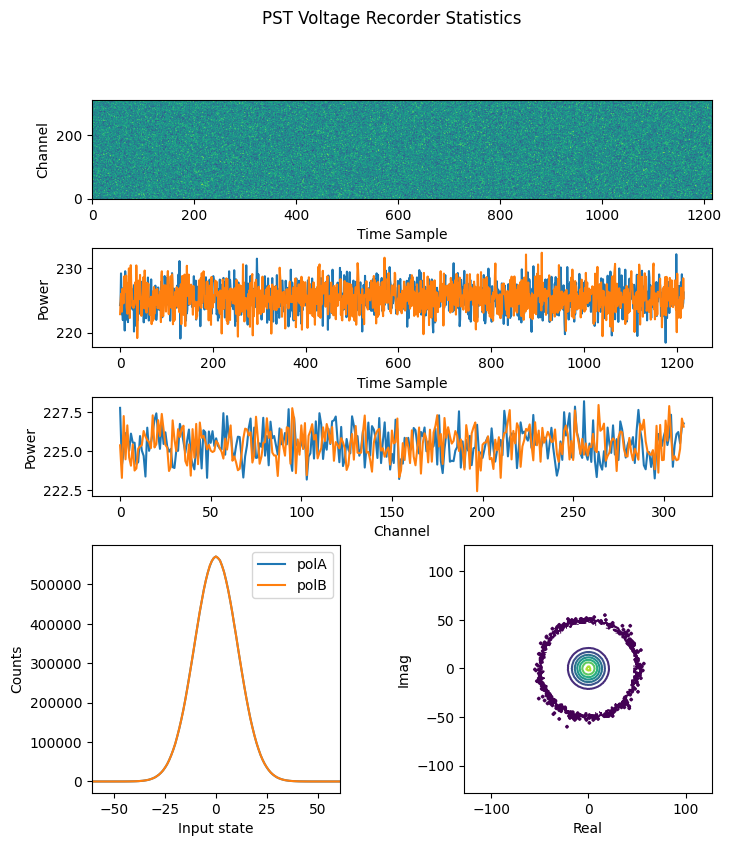

In [54]:
fig = plt.figure(figsize=(8, 9))
fig.suptitle("PST Voltage Recorder Statistics")

gs = plt.GridSpec(5, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])
ax4 = plt.subplot(gs[3:, 0])
ax5 = plt.subplot(gs[3:, 1])

# Spectrogram Plot
spectrogram_pol_a = stats.pol_a_spectrogram
mean = np.mean(spectrogram_pol_a)
stddev = np.std(spectrogram_pol_a)
minval = float(mean - 2.0 * stddev)
maxval = float(mean + 2.0 * stddev)
ax1.imshow(spectrogram_pol_a, origin="lower", vmin=minval, vmax=maxval, aspect="auto")
ax1.set_xlabel("Time Sample")
ax1.set_ylabel("Channel")

# Timeseries Plot
pol_a_timeseries = stats.pol_a_timeseries
pol_b_timeseries = stats.pol_b_timeseries

ax2.plot(pol_a_timeseries["Mean"], label="polA")
ax2.plot(pol_b_timeseries["Mean"], label="polB")
ax2.set_ylabel("Power")
ax2.set_xlabel("Time Sample")

# Spectral Power Plot
pol_a_spectral_power = stats.pol_a_spectral_power
pol_b_spectral_power = stats.pol_b_spectral_power

ax3.plot(pol_a_spectral_power["Mean"], label="polA")
ax3.plot(pol_b_spectral_power["Mean"], label="polB")
ax3.set_xlabel("Channel")
ax3.set_ylabel("Power")

# Histogram
pol_a_real_histogram = stats.pol_a_real_histogram
pol_a_imag_histogram = stats.pol_a_imag_histogram

# find last zero count before any counts


def find_count_bounds(df: pd.DataFrame, column: str = "Count") -> Tuple[int, int]:
    nonzeros = df[df[column] != 0].index
    return (nonzeros[0], nonzeros[-1])  # type: ignore


nbin = stats.metadata.histogram_nbin
pol_a_real_histogram = stats.pol_a_real_histogram
pol_b_real_histogram = stats.pol_b_real_histogram

(pol_a_low_idx, pol_a_high_idx) = find_count_bounds(stats.pol_a_real_histogram)
(pol_b_low_idx, pol_b_high_idx) = find_count_bounds(stats.pol_b_real_histogram)

low_idx = max(0, min(pol_a_low_idx, pol_b_low_idx) - 1)
high_idx = min(nbin - 1, max(pol_a_high_idx, pol_b_high_idx) + 1)
centre_idx = nbin // 2
diff = max(np.abs(centre_idx - low_idx), np.abs(high_idx - centre_idx))
low_idx = max(0, centre_idx - diff)
high_idx = min(nbin - 1, centre_idx + diff)

xbins = np.arange(low_idx, high_idx + 1)
pol_a_real_histogram = pol_a_real_histogram.iloc[xbins]["Count"]  # type: ignore
pol_b_real_histogram = pol_b_real_histogram.iloc[xbins]["Count"]  # type: ignore

xbins = xbins - centre_idx

ax4.set_xlim((xbins[0], xbins[-1]))
ax4.plot(xbins, pol_a_real_histogram, label="polA")
ax4.plot(xbins, pol_b_real_histogram, label="polB")
ax4.set_xlabel("Input state")
ax4.set_ylabel("Counts")
ax4.legend()

# 2D Histogram
pol_a_2d_data = stats.pol_a_rebinned_histogram2d
nrebin = stats.metadata.nrebin
n = nrebin // 2
histogram_bounds = np.arange(-n, n)
ax5.contour(histogram_bounds, histogram_bounds, pol_a_2d_data)
ax5.set_xlabel("Real")
ax5.set_ylabel("Imag")

plt.show()

## Metadata Verification

PST provides a Python API to help verify that the metadata in output files from a PST scan are what is expected based on the scan configuration and scan id used to generate the files.

Currently only the voltage recorder observation mode produces any output files, but this API will be extended in the future to support the different output files.

For more information see the [PST API - Metadata Mapping](https://developer.skao.int/projects/ska-pst/en/latest/api/metadata_mapping.html) about the mapping between the scan configuration and the various output file's metadata

In [55]:
metadata_verifier = MetadataVerifier(
    scan_configuration=scan_config,
    scan_id=scan_id,
    logger=logger,
)

Verify the output. If there is a mismatch between any of the scan configuration and the output metadata then this will raise an `AssertionError`

In [56]:
metadata_verifier.verify()

To visualise the metadata, the `MetadataVerifier` class also exposes a `dataframe` property that returns a Pandas dataframe that in Jupyter notebooks outputs a HTML table.

In [57]:
df = metadata_verifier.dataframe

with pd.option_context(
    "display.max_rows",
    None,
):
    display(df)

Keys                        Scan Configuration  \
0            execution_block_id                    eb-d509-20241119-53153   
1                       scan_id                                       103   
2                     udp_nsamp                                        32   
3                      wt_nsamp                                        32   
4                     udp_nchan                                        24   
5                   receiver_id                                       LOW   
6             feed_polarization                                       LIN   
7               feed_handedness                                         1   
8                    feed_angle                                      45.0   
9            feed_tracking_mode                                        FA   
10          feed_position_angle                                       0.0   
11                    receptors          [SKA002, SKA007, SKA030, SKA036]   
12             receptor_weights                  [0.23, 0.21, 0.29, 0.27]   
13         num_of_polarizations                                         2   
14              bits_per_sample                                        32   
15           oversampling_ratio                                    [4, 3]   
16               frequency_band                                       low   
17               timing_beam_id                                         8   
18              activation_time                  2024-11-19T21:32:24.313Z   
19                     observer                           observer_small6   
20                   project_id                        project_sceptical3   
21                  pointing_id                          pointing_sturdy7   
22                  subarray_id                                         1   
23                       source                                J1901+0300   
24                         itrf  [5109360.133, 2006852.586, -3238948.127]   
25          coordinates/equinox                                    2000.0   
26               coordinates/ra                                19:01:59.6   
27              coordinates/dec                                   3.00647   
28              max_scan_length                                      30.0   
29               test_vector_id                                             
30              total_bandwidth                            1128472.222222   
31                        nchan                                       312   
32             centre_frequency                          163539858.217593   
33                bandwidth_out                            1128472.222222   
34              ft/num_bits_out                                             
35             ft/polarizations                                             
36                  ft/channels                                             
37      ft/requantisation_scale                                             
38  ft/requantisation_init_time                                             
39                     nsubband                                             
40                     coord_md                                             
41                     trk_mode                                             
42                start_channel                                             
43                  end_channel                                             
44            start_channel_out                                             
45              end_channel_out                                             
46                    nchan_out                                             
47                     freq_out                                             
48                         ndim                                             
49                        tsamp                                             
50             bytes_per_second                                             
51                    t

#### Clean up

When finished, please remember to un-install the ska-pst chart (refer to instructions at top of page).